In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from skimage import io

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Alinhamento de imagens obtidas por VANTs

Imagens obtidas por VANTs apresentam:
    
* diferenças de **orientação** devidas à posição do veículo (rotações, translações);
* diferenças de **escala** devidas
  * à altura do veículo e
  * à resolução de diferentes sensores;
* diferenças de **perspectiva** (*tilt*, inclinação do veículo).

Grupos de pesquisa que realizam fenotipagem de campo empregram **marcadores**, objetos conhecidos que são visíveis nas imagens obtidas pelo VANT. Ver:

Liebisch *et al.* *Plant Methods* (2015) 11:9 [DOI 10.1186/s13007-015-0048-8](http://dx.doi.org/10.1186/s13007-015-0048-8).

Abaixo, temos um exemplo com imagens sintéticas. Uma corresponde a uma **imagem no espectro visível**, RGB, enquanto a outra corresponde a uma **imagem térmica**, de menor resolução, em que o *tilt* da aeronave causou uma **transformação perspectiva**.

In [2]:
I_rgb = io.imread('data/toy-birdview-rgb-input.jpg')
I_thermo = np.array(io.imread('data/toy-birdview-thermo-input.png')[:,:,0], dtype=np.float32)
I_thermo = I_thermo/255 * 50.

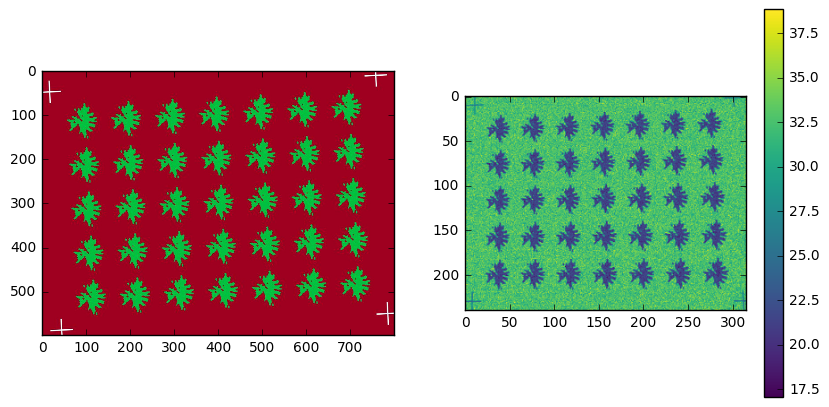

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(I_rgb)

plt.subplot(1,2,2)
plt.imshow(I_thermo, cmap=plt.cm.viridis)
plt.colorbar()

Quatro marcadores foram inseridos para que correções, na forma de **transformações projetivas**, possam ser realizadas. Assumindo um mapa conhecido para as parcelas, determinamos que os 4 marcadores devem ser mapeados para os seguintes pontos:

In [4]:
src = np.array([[30, 30], [770, 30], [30, 570], [770, 570]])

Buscando os marcadores na imagem RGB, observamos que eles se encontram nas seguintes coordenadas:

In [5]:
dst_rgb = np.array([[16, 48], [757, 12], [45, 589], [785, 550]])

O módulo `transform` no pacote scikit-image é capaz de estimar a transformação e aplicá-la a imagem:

In [6]:
from skimage import transform as tf

In [7]:
tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst_rgb)
warped_rgb = tf.warp(I_rgb, tform3)

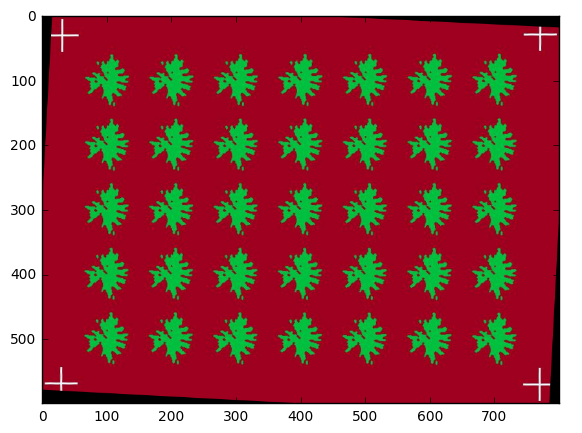

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(warped_rgb)

O mesmo pode ser feito com a imagem térmica. Nela, encontramos os marcadores nas posições:

In [9]:
dst_thermo = np.array([[10, 10], [301, 2], [7, 230], [312, 229]])

In [10]:
tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst_thermo)
warped_thermo = tf.warp(I_thermo/50., tform3, output_shape=(600,800))
warped_thermo = warped_thermo * 50

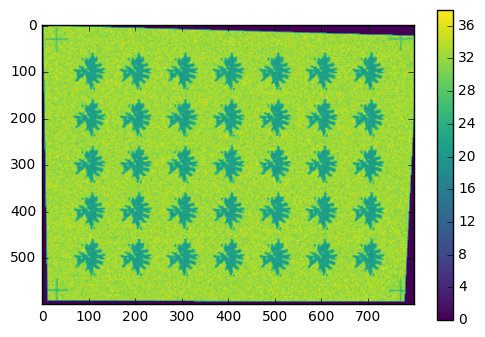

In [11]:
plt.imshow(warped_thermo, cmap=plt.cm.viridis)
plt.colorbar()

Agora as duas imagens estão alinhadas:

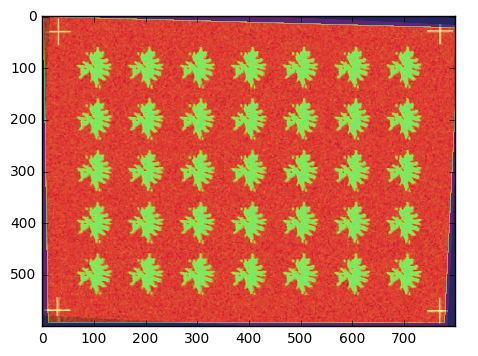

In [12]:
plt.imshow(warped_rgb, interpolation='nearest', alpha=0.7, cmap=plt.cm.viridis)
plt.imshow(warped_thermo, interpolation='nearest', alpha=0.5, )

Com as imagens alinhadas, finalmente podemos estabelecer relações entre elas. Abaixo, utilizamos a imagem RGB para identificar os pixeis correspondentes às plantas:

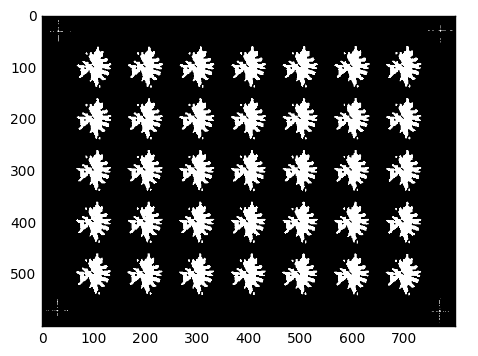

In [13]:
plant = warped_rgb[:,:,1] > warped_rgb[:,:,0]
plt.imshow(plant, cmap=plt.cm.binary_r)

In [14]:
import seaborn

Vamos demarcar nossa **região de interesse**, removendo os marcadores e demais áreas indesejadas:

In [15]:
thermo_roi = warped_thermo[35:565,35:765]
plant_roi = plant[35:565,35:765]

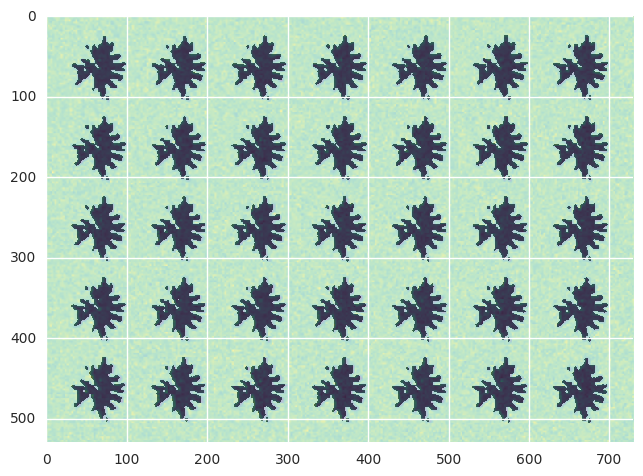

In [16]:
plt.imshow(thermo_roi, interpolation='nearest', alpha=0.7, cmap=plt.cm.viridis)
plt.imshow(plant_roi, interpolation='nearest', alpha=0.5, )

Com a máscara obtida a partir da imagem RGB, podemos identificar as temperaturas das plantas na imagem termal:

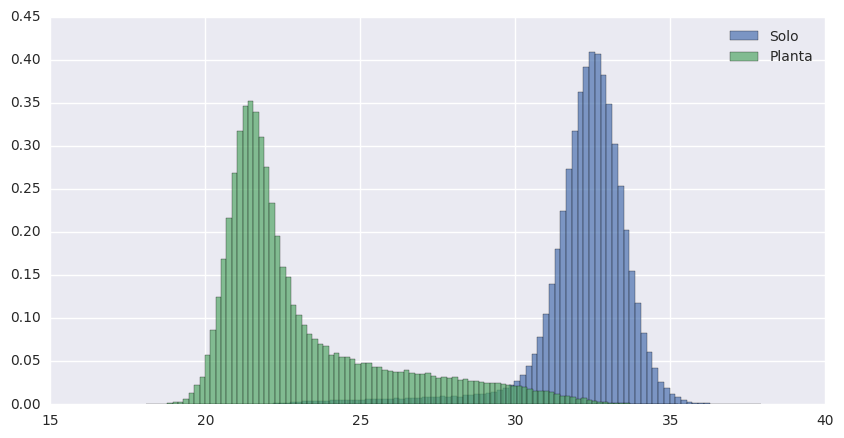

In [17]:
plt.figure(figsize=(10,5))
h_termo_soil = plt.hist(thermo_roi[plant_roi == False], bins=100, normed=True, alpha=0.7, label='Solo')
h_thermo_plant = plt.hist(thermo_roi[plant_roi], bins=100, normed=True, alpha=0.7, label='Planta')
plt.legend()